In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob

In [11]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [12]:
wpod_net_path = "./models/wpod/model.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [13]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 10 images...


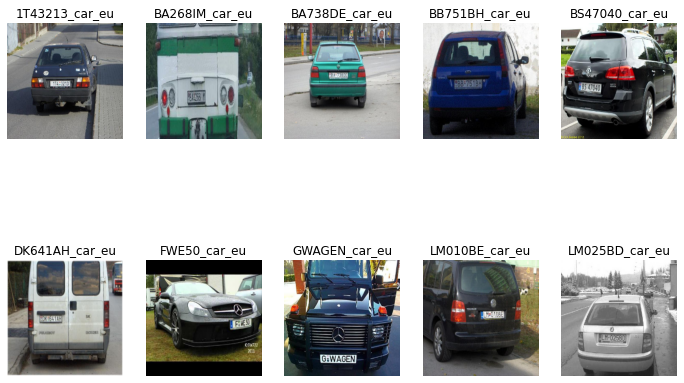

In [14]:
# Create a list of image paths 
image_paths = glob.glob("Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 2
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

# plt.tight_layout(True)
plt.show()


In [15]:
Image=1

Detect 1 plate(s) in BA268IM_car_eu
Coordinate of plate(s) in image: 
 [array([[241.40105641, 334.44677022, 335.96311572, 242.91740192],
       [131.43808126, 130.70355806, 153.62999708, 154.36452028],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


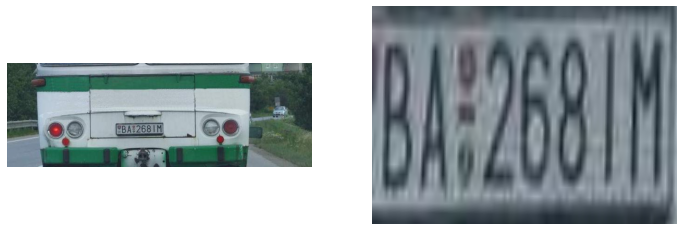

In [16]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = image_paths[Image]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

In [17]:
import tensorflow as tf
print(tf.__version__)

2.8.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


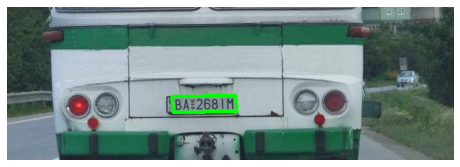

In [18]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

In [19]:
print(cor)

[array([[241.40105641, 334.44677022, 335.96311572, 242.91740192],
       [131.43808126, 130.70355806, 153.62999708, 154.36452028],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


In [20]:
#print predicted coordinates for comparison
Xmin=cor[0][0][0]
Ymin=cor[0][1][0]
Xmax=cor[0][0][2]
Ymax=cor[0][1][2]
coordinates=[Xmin,Ymin,Xmax,Ymax]
print(coordinates)

[241.40105641209024, 131.43808126233913, 335.96311572276926, 153.62999708303497]


In [21]:
image_paths_xml = glob.glob("Plate_examples_xml/*.xml")
test_image_xml = image_paths_xml[Image]

In [22]:
#extract correct/actual coordinates from .xml for image (trainingdata) at the given path
import xml.etree.ElementTree as ET
mytree = ET.parse(test_image_xml)
myroot=mytree.getroot()
print(myroot[0].tag)

object


In [23]:
#put actuall coordinates in an array
actuallcoord=[]

for x in myroot[0]:      
        print(x.text)
        val=int(x.text)
        actuallcoord.append(val)
        
        
Xmin_act=actuallcoord[0]    
Ymin_act=actuallcoord[1]
Xmax_act=actuallcoord[2]
Ymax_act=actuallcoord[3]

print("actuall coord are:",actuallcoord)
print("Xmin is:",actuallcoord[0])
print("Ymin is:",actuallcoord[1])
print("Xmax is:",actuallcoord[2])
print("Ymax is:",actuallcoord[3])

233
128
336
152
actuall coord are: [233, 128, 336, 152]
Xmin is: 233
Ymin is: 128
Xmax is: 336
Ymax is: 152


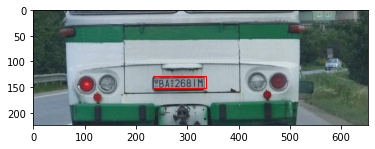

In [24]:
#draw box in red for actuall coordinates
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open(test_image)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)
# Create a Rectangle patch
rect = patches.Rectangle((Xmin_act, Ymin_act), Xmax_act-Xmin_act, Ymax_act-Ymin_act, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [25]:
#calculate Intersection over Union between predicted coordinates and actuall coordinates
def IOU(actuallcoord, coordinates):
    xl, yl, x2, y2 = actuallcoord 
    x3, y3, x4, y4 = coordinates 
    x_interl = max(xl, x3) 
    y_interl = max(yl, y3) 
    x_inter2 = min(x2, x4) 
    y_inter2 = min(y2, y4)
    width_inter = abs(x_inter2 - x_interl) 
    height_inter = abs( y_inter2 - y_interl)
    area_inter = width_inter * height_inter
    width_boxl = abs(x2 - xl) 
    height_boxl = abs(y2 - yl) 
    width_box2 = abs(x4 - x3) 
    height_box2 = abs(y4- y3) 
    area_boxl = width_boxl * height_boxl
    area_box2 = width_box2 * height_box2
    area_union = area_boxl + area_box2 - area_inter 
    iou = area_inter / area_union
    return iou

#give ratio of Intersection over Union 
print(IOU(actuallcoord,coordinates))

    
    

0.7403948110211644


## The End of part 1!